<a href="https://colab.research.google.com/github/JCScheunemann/Alfred/blob/master/training_model_umi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Carregamento das Libs

In [ ]:

import numpy as np
import pickle

import tensorflow as tf
from keras.models import Sequential 

#Dense layer is the output layer
from keras.layers import Dense, LSTM,Activation,Conv1D

from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time
import os



Using TensorFlow backend.


In [ ]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu, steps_per_run=128) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /job:localhost/replica:0/task:0/device:GPU:0
Number of accelerators:  1


Carrega os dados


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
src_dir='/content/drive/My Drive/Projetos/solo/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:

#load data 
data=None
with open(src_dir+"data.txt", "rb") as fp:   # Unpickling
    data = pickle.load(fp)
data_in=np.array(data[0]).T.astype('float32') 
data_out=np.array(data[1]).T.astype('float32') /100

n_in=len(data[0])
print(data_in.shape)

scaler = MinMaxScaler(feature_range=(0, 1))
data_in= scaler.fit_transform(data_in)

x_train, x_test, y_train, y_test = train_test_split( data_in, data_out, test_size=0.25, random_state=42)


(1879, 8)


Criação do modelo

In [ ]:

model = Sequential()
activ=['softsign','softsign','softsign']
model.add(Dense(15*n_in, input_dim=n_in, kernel_initializer='normal', activation=activ[0]))
model.add(Dense(8*n_in,  kernel_initializer='normal', activation=activ[1]))
model.add(Dense(4*n_in,  kernel_initializer='normal', activation=activ[2]))
model.add(Dense(1, kernel_initializer='normal',activation='relu'))
# Compile model
start = time.time()
model.compile(loss='logcosh', optimizer='adam',metrics=['mae'])
model.summary()
'''


tf.keras.backend.clear_session()

resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)
#tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)

start = time.time()
with strategy.scope():
  model = Sequential()
  model.add(Dense(15*n_in, input_dim=n_in, kernel_initializer='normal', activation='relu'))
  model.add(Dense(8*n_in,  kernel_initializer='normal', activation='tanh'))
  model.add(Dense(4*n_in,  kernel_initializer='normal', activation='tanh'))
  model.add(Dense(1, kernel_initializer='normal',activation='relu'))
  model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae'])
  umi=model.fit(x_train, y_train, epochs=800, batch_size=50, verbose=1)

'''


umi=model.fit(x_train, y_train, epochs=800,  verbose=1)
end = time.time()
print(end - start)

NameError: ignored

Test Score: 1.56 RMSE


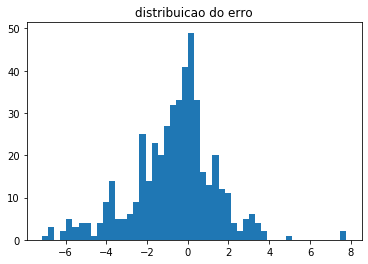

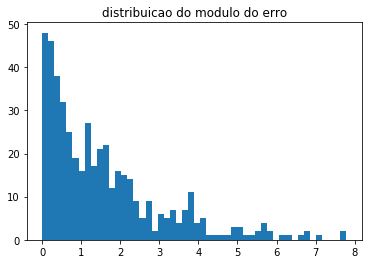

In [ ]:
Predict = model.predict(x_test)
testScore = math.sqrt(mean_squared_error(y_test, Predict))
erro=(y_test.reshape((Predict.shape[0], 1))- Predict)*100
print('Test Score: %.2f RMSE' % (np.mean(np.abs(erro))))
#print( Predict-y_test)
plt.hist(erro,  bins=50)
plt.title("distribuicao do erro")
plt.show()
plt.hist(np.abs(erro),  bins=50)
plt.title("distribuicao do modulo do erro")
plt.show()